# Lab 6: RNN: Google Stocks prediction

Во оваа лабораториска вежба се тренира RNN модел за предвидување на висината на акциите.
Треба да се предвиди цената со која ќе се отворат акциите на Google за месец јануари, 2017 година (почнувајќи од 03.01.2017). За анализа, тренирање и тестирање се користат податоци од акциите на Google од 2012 - 2016 година.
За секој ден дадени се карактеристиките:
    Open - цената со која се отвара трговијата на акции за тој ден
    High - највисоката цена што се достигнува во трговијата на акции во текот на денот
    Low - најниската цена што се достигнува за време на денот
    Close - последната цена на тргување за време на тој ден
    Volume - вкупниот број на акции истргувани во текот на тој ден
Обработката на податоците (тренирањето и тестирањето) се прави само на првата карактеристика (open price). Другите четири се изоставаат.

## Import libraries

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math

from keras.callbacks import EarlyStopping
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## Import the Google Stock price datasets

Со помош на библиотеката pandas се читаат датотекатите кои ги содржат множествата множествата за тестирање и тренирање.

train_dataset = pd.read_csv('IA-Lab7 - Google_Stock_Price_Train.csv')
train_dataset

In [38]:
test_dataset = pd.read_csv('IA-Lab7 - Google_Stock_Price_Test.csv')
test_dataset

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [39]:
train_data = train_dataset.iloc[:,1:2].values
test_data = test_dataset.iloc[:,1:2].values

In [40]:
train_data

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [9]:
test_data

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

## Scaling

Скалирање на податоците во обем од 0 до 1, со minmaxScaler() функцијата

In [41]:
scaler = MinMaxScaler() #default od 0 do 1
train_data = scaler.fit_transform(train_data)

In [42]:
train_data

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [43]:
inputs = scaler.transform(test_data)

In [44]:
inputs

array([[0.92955205],
       [0.94731751],
       [0.94307612],
       [0.96015329],
       [0.98087655],
       [0.98359253],
       [0.97827219],
       [0.98225314],
       [0.98288563],
       [0.98214153],
       [0.979779  ],
       [0.97849542],
       [0.98182528],
       [0.98245777],
       [1.01045465],
       [1.02407173],
       [1.03930724],
       [1.03354044],
       [0.99624228],
       [0.9631297 ]])

In [45]:
train_data.size

1258

In [46]:
inputs.size

20

## Partitioning data into features/labels

Поделба на податоците во променливите X и Y, соодветно. Х - feture vectors... Y - класата

In [47]:
x_train = train_data[:-1]
y_train = train_data[1:]

## Build the model

Градење на рекурентната невронска мрежа бара конфигурирање на слоевите од моделот, а потоа компајлирање на моделот.

### Преобликување (reshaping) на влезните податоци за да се прилагодат на RNN слоевите во Keras

x_train = np.reshape(x_train, (1257, 1, 1))
inputs = np.reshape(inputs, (20, 1, 1))

### Дефинирање на моделот со рекурентна невронска мрежа

In [48]:
regressor = Sequential()
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))
regressor.add(Dense(units = 1))

d:\Programs\Anaconda\envs\IA\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM е влезен слој со активациска функција sigmoid.
Излезен е Dense слојот со еден јазол.

### Compile the model

In [49]:
regressor.compile(optimizer = 'adam', 
                  loss = 'mean_squared_error')

## Train the model

In [50]:
regressor.fit(x_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3322
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2375
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1768  
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1375
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1068 
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0985
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0819  
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0832  
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0765 
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0763
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0728
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0752  
Epoch 13/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0723  
Epoch 14/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0703
Epoch 15/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

## Make predictions

In [51]:
predicted = regressor.predict(inputs)
predicted = scaler.inverse_transform(predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


In [52]:
predicted[0]

array([768.7717], dtype=float32)

In [53]:
test_data[0]

array([778.81])

In [54]:
predicted.shape

(20, 1)

In [55]:
test_data.shape

(20, 1)

## Evaluate accuracy (MAE & RMSE)

In [56]:
rmse = math.sqrt(mean_squared_error(test_data, predicted))
print('Test Root Mean Squared Error:', rmse)
mae = mean_absolute_error(test_data, predicted)
print('Test Mean Absolute Error:', mae)

Test Root Mean Squared Error: 16.51454335546257
Test Mean Absolute Error: 16.165111328124993


## Visualizing Actual Google Stock Price vs Predicted Google Stock Price

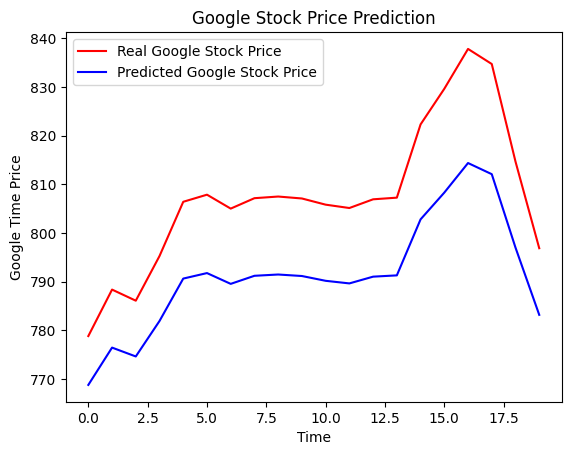

In [57]:
plt.figure()
plt.plot(test_data, color='red', label = 'Real Google Stock Price')
plt.plot(predicted, color='blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Time Price')
plt.legend()
plt.show()

## MAE plot

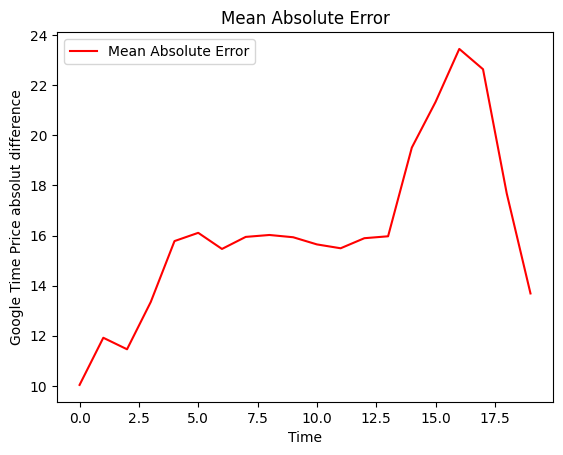

In [58]:
plt.figure()
plt.plot(np.abs(test_data - predicted), color='red', label = 'Mean Absolute Error')
plt.title('Mean Absolute Error')
plt.xlabel('Time')
plt.ylabel('Google Time Price absolut difference')
plt.legend()
plt.show()

# TODO

Креирај модел со 4 RNN (LSTM) и еден Dense слој.

- Прв LSTM слој со 50 јазли со вклучени return_sequences и без активациска функција. После тој слој dropout слој со стапка на испуштање од 20%.
- Втор LSTM слој повторно со 50 јазли, а следен од dropout слој со стапка на испуштање од 20%.
- Трет LSTM слој со ист број на јазли како и претходните и следен од dropout слој повторно од иста стапка на испуштање.
- Последниот пар на LSTM и dropout слоеви со исти карактеристики како и претходните три.
- На крај како излезен слој вклучи Dense слој со еден јазол.

In [59]:
regressor = Sequential()

# First LSTM layer with Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(None, 1)))
regressor.add(Dropout(0.2))

# Second LSTM layer with Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer with Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer with Dropout regularization
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

print(regressor.summary())

d:\Programs\Anaconda\envs\IA\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, None, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, None, 50)       │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, None, 50)       │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, None, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None


Искомпалирај го моделот со (optimizer = 'adam', loss = 'mean_squared_error').

In [60]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

Истренирај го моделот со 100 епохи и batch_size од 32, а потоа пробај и со различен број на епохи.

In [61]:
regressor.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2508
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 13/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 14/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 15/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoc

Најди ја точноста со евалуациските метрики MAE и MSE.

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, predicted)
print('Test Mean Absolute Error:', mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data, predicted)
print('Test Mean Squared Error:', mse)

Test Mean Absolute Error: 16.165111328124993
Test Mean Squared Error: 272.73014223945296


Покажи го предвидувањето за 20 јануари, исто така испечати го и излезот од тест множеството за тој ден и спореди ги.

In [63]:

# Predicted value for January 20th
predicted_value = predicted[12][0]

# Actual value for January 20th
actual_value = test_data[12][0]

print(f"Predicted value for January 20th: {predicted_value}")
print(f"Actual value for January 20th: {actual_value}")

Predicted value for January 20th: 791.01708984375
Actual value for January 20th: 806.91


Визуелизирај ги вистинските наспроти предвидените вредности од тест множеството.

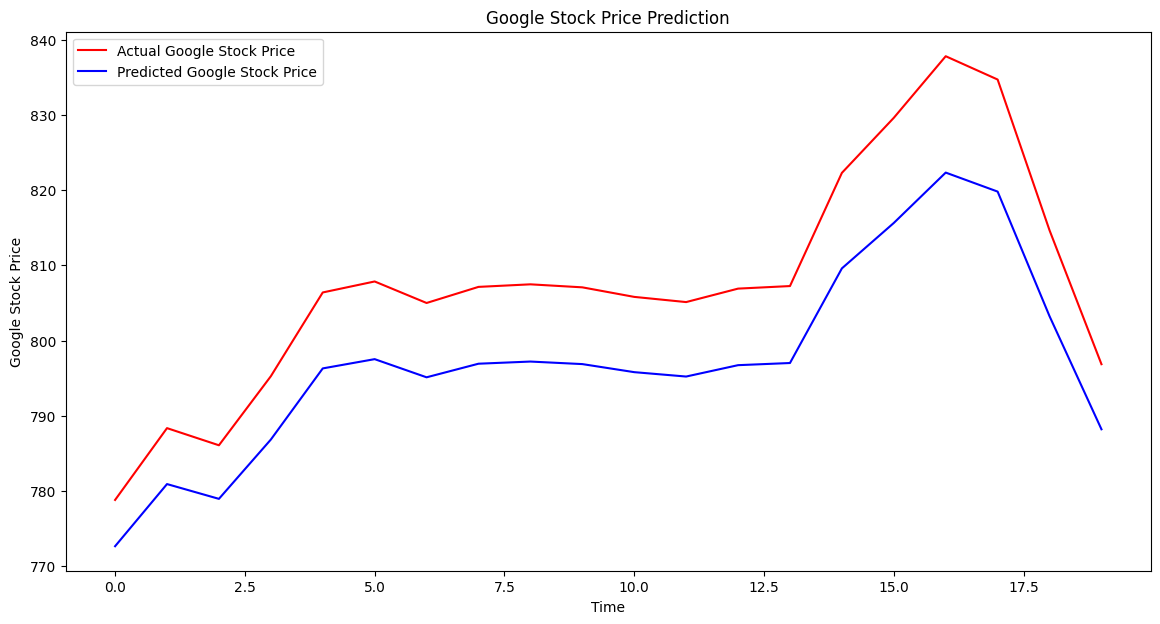

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(test_data, color='red', label='Actual Google Stock Price')
plt.plot(predicted, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

Исцртај го графикот за RMSE од тест множеството.

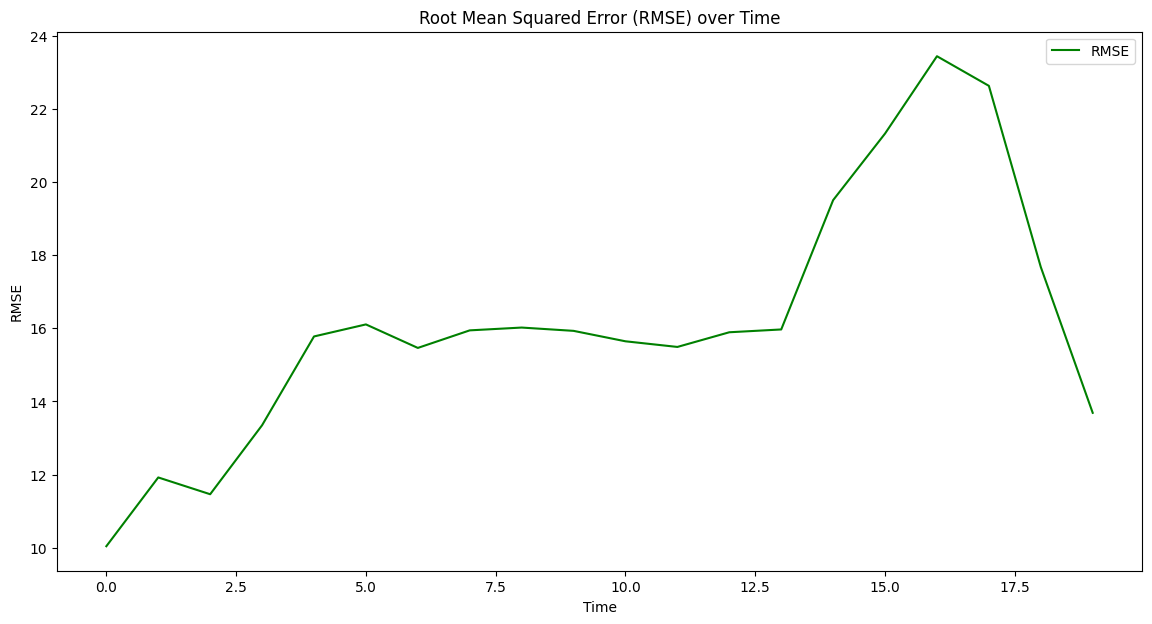

In [64]:
rmse_values = np.sqrt((test_data - predicted) ** 2)

plt.figure(figsize=(14, 7))
plt.plot(rmse_values, color='green', label='RMSE')
plt.title('Root Mean Squared Error (RMSE) over Time')
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.legend()
plt.show()